In [1]:
!pip install -q kaggle

In [ ]:
import os
import json
from pathlib import Path
from glob import glob
import os
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pickle

# # --- mon token kaggle ---
# kaggle_data = {
    
# }
# # ------------------------------------------------------

# Création du dossier caché
os.makedirs('/root/.kaggle', exist_ok=True)

# Écriture du fichier sur le serveur Colab
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_data, f)

# Permissions de sécurité
os.chmod('/root/.kaggle/kaggle.json', 600)

In [3]:

!kaggle datasets download -d fahadullaha/facial-emotion-recognition-dataset
!unzip -q facial-emotion-recognition-dataset.zip -d fer_dataset


Dataset URL: https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 76% 152M/200M [00:00<00:00, 1.58GB/s]
100% 200M/200M [00:00<00:00, 1.13GB/s]


In [4]:
emotion_Dict = dict(angry=1, disgust=2, fear=3, happy=4, neutral=0, sad=5, surprise=6)
idx_to_class = {v: k for k, v in emotion_Dict.items()}

In [ ]:
import matplotlib.pyplot as plt
import torch

def show_image(img, title=None):
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0)      
        img = img * 0.5 + 0.5
        img = img.clamp(0, 1)

    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

import matplotlib.pyplot as plt
import torchvision

def show_batch(images, labels=None, n_images=32):
    """
    Affiche un batch d'images avec les noms de classes
    """
    images = images[:n_images]
    if labels is not None:
        labels = labels[:n_images]

    # Crée la grille
    grid_img = torchvision.utils.make_grid(images, nrow=min(n_images, 8), normalize=True)
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(12, 6))
    plt.imshow(np_img)
    plt.axis('off')

    if labels is not None:
        nrow = min(n_images, 8)
        for i in range(len(images)):
            row = i // nrow
            col = i % nrow

            # Coordonnées
            x = col * images.shape[3] + 2
            y = row * images.shape[2] + 10

            valeur_numerique = labels[i].item()
            nom_emotion = idx_to_class.get(valeur_numerique, "Inconnu")

            plt.text(x, y, nom_emotion, color='white', fontsize=10,
                     backgroundcolor='black', weight='bold')

    plt.show()


In [7]:
class FER:
    def __init__(self, root: Path, extension: str = "jpg", train_size: float = 0.8):
        self.root = root
        all_paths = glob(f"{root}/*/*.{extension}")
        all_labels = [os.path.basename(os.path.dirname(p)) for p in all_paths]

        self.train_paths, self.test_paths, self.train_labels, self.test_labels = train_test_split(
            all_paths, all_labels, train_size=train_size, stratify=all_labels, random_state=42
        )

    def save(self, filename: str):
        with open(filename, 'wb') as f:
            pickle.dump({
                "train": (self.train_paths, self.train_labels),
                "test": (self.test_paths, self.test_labels)
            }, f)

    def load(self, filename: str):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            self.train_paths, self.train_labels = data["train"]
            self.test_paths, self.test_labels = data["test"]

fer = FER(root=Path("/content/fer_dataset/processed_data"), train_size= 0.9)
fer.save("train.pyc")
fer.load("train.pyc")

In [8]:
class FERDataset(Dataset):
    def __init__(self, dataset, transform=None, train: bool=True):
            if train :
                self.paths = dataset.train_paths
                self.labels = dataset.train_labels
            else :
                self.paths = dataset.test_paths
                self.labels = dataset.test_labels

            self.dataset = dataset
            self.transform = transform
            self.emotion_to_class = dict(angry=1, disgust=2, fear=3, happy=4, neutral=0, sad=5, surprise=6)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image_path = self.paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        #label = os.path.basename(os.path.dirname(image_path))
        label = self.emotion_to_class[label]

        return image, label


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

dataset_train = FERDataset(fer, transform=transform, train = True)

dataset_valid = FERDataset(fer, transform=transform, train = False)

In [9]:
from torch.utils.data import DataLoader


dataloader_train = DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=8
)

dataloader_valid = DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=8
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


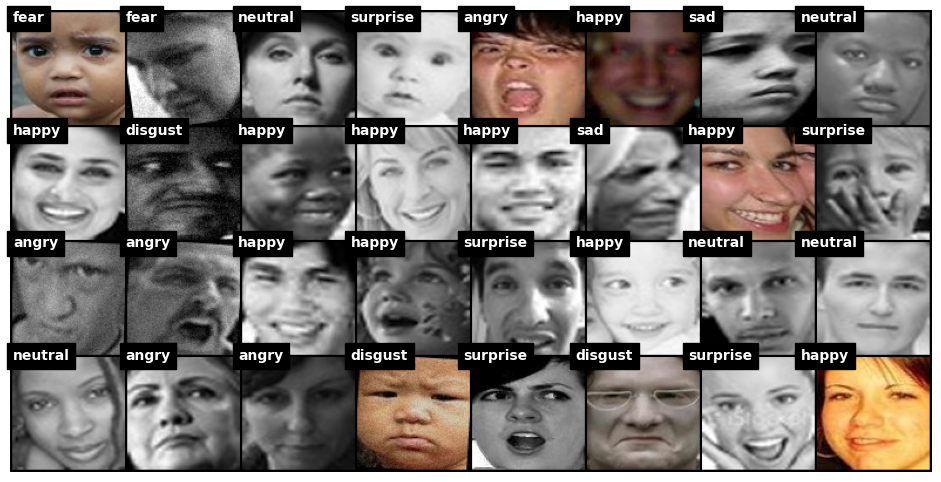

In [10]:
data = next(iter(dataloader_valid))
images , labels = data
show_batch(images, labels=labels)

# ZERO SHOT & CLIP

##

In [11]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-durc006w
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-durc006w
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=e74ae8fbb6d8cc515ff54ce359279476457cc2306bcd8cdc758b23aaf966d0aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-b4xz672d/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [12]:
import torch
import clip
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 153MiB/s]


In [ ]:
# @title Zero shot with Clip model
emotions_prompt = {
    "neutral": "a neutral, expressionless face",
    "angry": "an angry, furious facial expression",
    "disgust": "a disgusted, repulsed face",
    "fear": "a scared, terrified person",
    "happy": "a happy, smiling face",
    "sad": "a sad, sorrowful face",
    "surprise": "a surprised, shocked facial expression"
}

prompts = [f"a photo of {desc}" for desc in emotions_prompt.values()]

# emotions_prompt = {
#     "neutral": "a calm and neutral human face with relaxed muscles and no visible emotion",
#     "angry": "an angry face with furrowed brows, tightened eyes, and a clenched jaw or pressed lips",
#     "disgust": "a disgusted expression with a wrinkled nose, raised upper lip, and squinted eyes",
#     "fear": "a terrified face with wide open eyes showing whites, raised eyebrows, and an open gasping mouth",
#     "happy": "a joyful smiling face with raised cheeks and crinkled skin around the corners of the eyes",
#     "sad": "a sad face with drooping upper eyelids, down-turned corners of the mouth, and pained eyebrows",
#     "surprise": "a shocked face with arched eyebrows, wide circular eyes, and a dropped open jaw"
# }

# On s'assure de respecter l'ordre de tes classes numériques
# ordered_emotions = ["neutral", "angry", "disgust", "fear", "happy", "sad", "surprise"]
# prompts = [emotions_prompt[e] for e in ordered_emotions]

text = clip.tokenize(prompts).to(device)
all_preds = []
all_labels = []

with tqdm(total=len(dataset_valid)) as pbar:
  for i in range(len(dataset_valid)):
    file_name = dataset_valid.paths[i]
    image = preprocess(Image.open(file_name)).unsqueeze(0).to(device)
    label =  dataset_valid.labels[i]
    label = emotion_Dict[label]
    all_labels.append(label)
    # data, labels =

    # print(labels)
    # data, labels = data.to(device), labels.to(device)
    with torch.no_grad():

      image_features = model.encode_image(image)
      text_features = model.encode_text(text)

      logits_per_image, logits_per_text = model(image, text)
      probs = logits_per_image.softmax(dim=-1).cpu()
      pred_idx = probs.argmax(axis=-1)
      all_preds.append(pred_idx.item())
    pbar.update(1)
    # if i ==10 :
    #   break

# --- Calcul des métriques avec Scikit-learn ---

# L'accuracy simple
accuracy = accuracy_score(all_labels, all_preds)

# Le F1-score (on utilise 'weighted' pour tenir compte du déséquilibre des classes)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f" Accuracy : {accuracy:.4f}")
print(f" F1-Score (Weighted) : {f1:.4f}")

# --- Rapport détaillé par émotion ---
print("\n Rapport de classification détaillé :")
# 'emotions' est ta liste ["neutral", "angry", ...] définie plus haut

emotions = [
  "neutral",
  "angry",
  "disgust",
  "fear",
  "happy",
  "sad",
  "surprise"
]

print(classification_report(all_labels, all_preds, target_names=emotions))


100%|██████████| 4978/4978 [03:17<00:00, 25.19it/s]

✅ Accuracy : 0.4134
✅ F1-Score (Weighted) : 0.4144

📊 Rapport de classification détaillé :
              precision    recall  f1-score   support

     neutral       0.28      0.58      0.38       817
       angry       0.47      0.34      0.39       592
     disgust       0.32      0.43      0.37       592
        fear       0.29      0.10      0.15       592
       happy       0.82      0.39      0.53      1140
         sad       0.41      0.53      0.47       653
    surprise       0.59      0.46      0.52       592

    accuracy                           0.41      4978
   macro avg       0.45      0.41      0.40      4978
weighted avg       0.49      0.41      0.41      4978



In [18]:
!wget -O image.jpg "https://media.istockphoto.com/id/137201859/photo/animal-humour.jpg?s=612x612&w=0&k=20&c=9etGNrTam8jY0AZcPJHGh0fQbV5ASR85NV8Yp3RPeuQ="

--2026-01-02 17:54:27--  https://media.istockphoto.com/id/137201859/photo/animal-humour.jpg?s=612x612&w=0&k=20&c=9etGNrTam8jY0AZcPJHGh0fQbV5ASR85NV8Yp3RPeuQ=
Resolving media.istockphoto.com (media.istockphoto.com)... 3.163.189.73, 3.163.189.37, 3.163.189.62, ...
Connecting to media.istockphoto.com (media.istockphoto.com)|3.163.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45008 (44K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  43.95K  --.-KB/s    in 0.007s  

2026-01-02 17:54:28 (6.47 MB/s) - ‘image.jpg’ saved [45008/45008]



torch.Size([49])


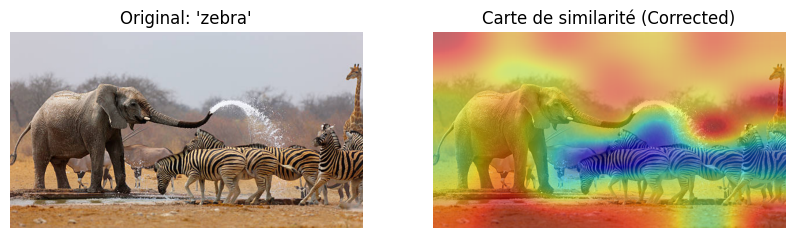

In [87]:
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model = model.float().eval()

def generate_clip_heatmap_final(image_path, text_query):
    image_raw = Image.open(image_path).convert("RGB")
    image_input = preprocess(image_raw).unsqueeze(0).to(device)
    text_input = clip.tokenize([text_query]).to(device)

    activations = []
    def hook_fn(module, input, output):
        activations.append(output)

    target_layer = model.visual.transformer.resblocks[-1]
    handle = target_layer.register_forward_hook(hook_fn)

    # Forward Pass
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_input)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Extraction et projection des patchs
        act = activations[0] # [50, 1, 768]
        patch_features = act[1:, 0, :] # [49, 768] (on ignore le CLS)

        # Projection dans l'espace joint (512 dimensions pour ViT-B/32)
        patch_features = patch_features @ model.visual.proj
        patch_features /= patch_features.norm(dim=-1, keepdim=True)

        # Calcul de similarité (Cosine similarity)
        heatmap_values = (patch_features @ text_features.T).squeeze()

    handle.remove()

    # --- LA CORRECTION EST ICI (.detach()) ---
    heatmap = heatmap_values.reshape(7, 7).detach().cpu().numpy()

    # Normalisation pour l'affichage
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # Upsampling
    heatmap_resized = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(image_raw.size, resample=Image.BICUBIC)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_raw)
    plt.title(f"Original: '{text_query}'")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image_raw)
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.title("Carte de similarité (Corrected)")
    plt.axis("off")
    plt.show()

generate_clip_heatmap_final("image.jpg", "zebra")

# CNN

In [60]:
# @title Moderl
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------
# BASIC BLOCK
# -------------------------------
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


# -------------------------------
# RESNET-16 (96x96 friendly)
# -------------------------------
class ResNet16_96(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_channels = 64

        # Conv initiale (pas de downsampling)
        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3,
            stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)

        # Stages ResNet
        self.layer1 = self._make_layer(64,  2, stride=1)  # 96x96
        self.layer2 = self._make_layer(128, 2, stride=2)  # 48x48
        self.layer3 = self._make_layer(256, 2, stride=2)  # 24x24
        self.layer4 = self._make_layer(512, 1, stride=2)  # 12x12

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []

        for s in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, s))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


# -------------------------------
# TEST
# -------------------------------
if __name__ == "__main__":
    model = ResNet16_96(num_classes=7)
    x = torch.randn(1, 3, 96, 96)
    y = model(x)
    print(y.shape)  # [1, 10]


torch.Size([1, 7])


In [ ]:
# @title Trainer
class Trainer:
  def __init__(self, model,
               dataloader_train,
               dataloader_test,
               config: dict):
    self.model = model
    self.dataloader_train = dataloader_train
    self.dataloader_test = dataloader_test
    self.optimizer = torch.optim.Adam(cnn_model.parameters(), lr=config["lr"])
    self.criterion = nn.CrossEntropyLoss()
    self.config = config

  def one_epoch(self):
    self.model.train()
    temps_accuracy_train = []
    temps_loss_train = []
    for batch in self.dataloader_train:
        self.optimizer.zero_grad()
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        preds = self.model(images)
        loss = self.criterion(preds, labels)
        temps_accuracy_train.append((preds.argmax(dim=-1) == labels).float().mean())
        temps_loss_train.append(loss.item())
        loss.backward()
        self.optimizer.step()
    return temps_accuracy_train, temps_loss_train

  def train(self):
    accuracy_train = []
    loss_train = []
    accuracy_valid = []
    loss_valid = []

    best_val_loss = float("inf")
    patience_counter = 0

    with tqdm(total=self.config["num_epochs"]) as pbar:
        for epoch in range(self.config["num_epochs"]):
            # -------- TRAIN --------
            temps_accuracy_train, temps_loss_train = self.one_epoch()
            mean_acc_train = torch.mean(torch.tensor(temps_accuracy_train))
            mean_loss_train = torch.mean(torch.tensor(temps_loss_train))

            accuracy_train.append(mean_acc_train)
            loss_train.append(mean_loss_train)

            # -------- VALID --------
            temps_accuracy_valid, temps_loss_valid = self.evaluate()
            mean_acc_valid = torch.mean(torch.tensor(temps_accuracy_valid))
            mean_loss_valid = torch.mean(torch.tensor(temps_loss_valid))

            accuracy_valid.append(mean_acc_valid)
            loss_valid.append(mean_loss_valid)

            # -------- CHECK BEST MODEL --------
            if mean_loss_valid < best_val_loss - self.config["min_delta"]:
                best_val_loss = mean_loss_valid
                patience_counter = 0

                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": self.model.state_dict(),
                        "optimizer_state_dict": self.optimizer.state_dict(),
                        "val_loss": best_val_loss,
                    },
                    self.config["checkpoint_path"]
                )

                status = " best model saved"

            else:
                patience_counter += 1
                status = f" patience {patience_counter}/{self.config['patience']}"

            # -------- EARLY STOP --------
            if patience_counter >= self.config["patience"]:
                pbar.set_description(" Early stopping triggered")
                break

            # -------- PROGRESS BAR --------
            pbar.set_description(
                f"Epoch {epoch+1} | "
                f"Train loss: {mean_loss_train:.4f} | "
                f"Val loss: {mean_loss_valid:.4f} | "
                f"{status}"
            )

            pbar.update(1)

    plt.plot(loss_train, label="train")
    plt.plot(loss_valid, label="valid")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(accuracy_train, label="train")
    plt.plot(accuracy_valid, label="valid")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


  def evaluate(self):
    self.model.eval()
    temps_accuracy_valid = []
    temps_loss_valid = []
    with torch.no_grad():
      for batch in self.dataloader_test:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        preds = self.model(images)
        loss = self.criterion(preds, labels)
        temps_accuracy_valid.append((preds.argmax(dim=-1) == labels).float().mean())
        temps_loss_valid.append(loss.item())
    return temps_accuracy_valid, temps_loss_valid

  def load_best_model(self):
    checkpoint = torch.load(self.config["checkpoint_path"])
    self.model.load_state_dict(checkpoint["model_state_dict"])
    self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    return checkpoint["val_loss"]



Epoch 10 | Train loss: 0.6268 | Val loss: 0.9219 | ⏳ patience 1/3: 100%|██████████| 10/10 [46:30<00:00, 279.09s/it]


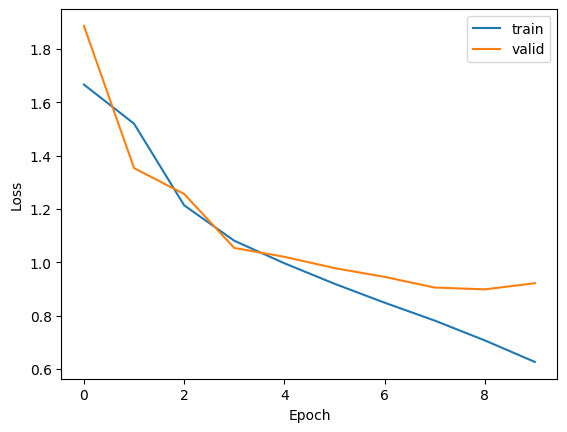

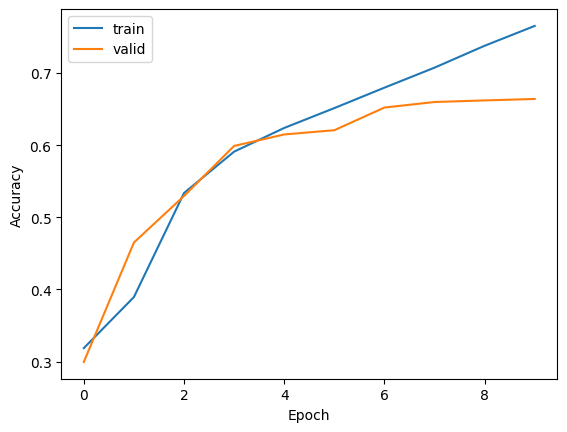

In [67]:
cnn_model = ResNet16_96(num_classes=7).to(device)

config = {
    "num_epochs": 10,
    "lr": 1e-3,
    "patience": 3,              # early stopping
    "min_delta": 1e-4,
    "checkpoint_path": "best_model.pth"
}

trainer = Trainer(cnn_model, dataloader_train, dataloader_valid, config)
trainer.train()